In [1]:
! mkdir -p /aiffel/model-fit/data #디렉토리 생성
! cp -r ~/data /aiffel/model-fit/ #  data 디렉토리 링크 설정

In [2]:
import os
import random

data_path = '/aiffel/model-fit/data/DATASET/TRAIN'
cls = [os.path.join(data_path, x) for x in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, x))]
cls

['/aiffel/model-fit/data/DATASET/TRAIN/goddess',
 '/aiffel/model-fit/data/DATASET/TRAIN/tree',
 '/aiffel/model-fit/data/DATASET/TRAIN/plank',
 '/aiffel/model-fit/data/DATASET/TRAIN/downdog',
 '/aiffel/model-fit/data/DATASET/TRAIN/warrior2']

In [3]:
cls_files = {}

for x in cls:
    if x not in cls_files:
        cls_files[x] = [f for f in os.listdir(x) if os.path.isfile(os.path.join(x, f))]
        
cls_files

{'/aiffel/model-fit/data/DATASET/TRAIN/goddess': ['00000282.png',
  '00000102.jpg',
  '00000108.jpg',
  '00000146.jpg',
  '00000281.jpg',
  '00000269.jpg',
  '00000246.jpg',
  '00000349.jpg',
  '00000346.jpg',
  '00000313.jpg',
  '00000272.png',
  '00000231.jpg',
  '00000278.png',
  '00000145.jpg',
  '00000380.jpg',
  '00000303.jpg',
  '00000137.jpg',
  '00000105.jpg',
  '00000176.jpg',
  '00000207.jpg',
  '00000198.jpg',
  '00000324.jpg',
  '00000164.jpg',
  '00000401.jpg',
  '00000276.jpg',
  '00000150.jpg',
  '00000096.jpg',
  '00000237.jpg',
  '00000217.jpg',
  '00000128.jpg',
  '00000381.jpg',
  '00000345.jpg',
  '00000250.jpg',
  '00000115.jpg',
  '00000285.jpg',
  '00000202.jpg',
  '00000154.jpg',
  '00000337.jpg',
  '00000117.jpg',
  '00000130.jpg',
  '00000169.jpg',
  '00000374.jpg',
  '00000398.jpg',
  '00000173.jpg',
  '00000258.jpg',
  '00000378.jpg',
  '00000110.jpg',
  '00000211.jpg',
  '00000182.jpg',
  '00000291.jpg',
  '00000377.jpg',
  '00000120.jpg',
  '00000392.jpg'

In [4]:
import random
import copy
import shutil

cls_val = {}
# 0.8, 0.2 비율로 기존의 TRAIN 셋을 나눠봅시다.
for x in cls:
    n_train_data = int(len(cls_files[x]) * 0.8) # train 비율 0.8
    n_val_data = len(cls_files[x]) - n_train_data # validation 비율 0.2
    print(len(cls_files[x]), n_train_data, n_val_data)
    train_data = random.sample(cls_files[x], n_train_data)
    val_data = copy.deepcopy(cls_files[x]) 
    
    for y in train_data: # TRAIN 폴더에서 VAL 폴더로 옮겨줄 데이터만 남기기
        val_data.remove(y)
        
    print(len(cls_files[x]), len(train_data), len(val_data))
    
    # 현재 클래스 디렉토리 생성
    x_cls = os.path.join('/aiffel/model-fit/data/DATASET/VAL', x.split('/')[-1])
    os.makedirs(x_cls, exist_ok=True)
    for y in val_data:
        shutil.move(os.path.join(x, y), os.path.join(x_cls, y))
#         print(os.path.join(x, y), os.path.join(x_cls, y))

180 144 36
180 144 36
160 128 32
160 128 32
266 212 54
266 212 54
223 178 45
223 178 45
252 201 51
252 201 51


In [5]:
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


def process_path(file_path, class_names, img_shape=(224, 224)):
    '''
    file_path로부터 class label을 만들고, 이미지를 읽는 함수
    '''
    label = tf.strings.split(file_path, os.path.sep)
    label = label[-2] == class_names

    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, img_shape)
    return img, label

In [6]:
def prepare_for_training(ds, batch_size=32, cache=True, shuffle_buffer_size=1000):
    '''
    TensorFlow Data API를 이용해 data batch를 만드는 함수
    '''
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return ds

In [7]:
def load_label(data_path):
    '''
    class 이름을 가져오는 함수
    '''
    class_names = [str(x) for x in data_path.iterdir()]
    print('Find {} class : {}'.format(len(class_names), class_names))
    return np.array(class_names)

In [8]:
def show_batch(image_batch, label_batch, class_names):
    '''
    데이터를 시각화해주는 함수
    '''
    size = len(image_batch)
    sub_size = size
    plt.figure(figsize=(10, 10), dpi=80)
    for n in range(size):
        plt.rc('font', size=10)
        plt.subplot(sub_size, sub_size, n+1)
        plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
        print(plt.title(class_names[label_batch[n]==True][0].title()))
        plt.title(label_batch[n].numpy().decode('utf-8'))
        plt.imshow(image_batch[n])
    plt.show()

In [9]:
def load_data(data_path, batch_size=32):
    '''
    데이터를 만들기 위해 필요한 함수들을 호출하고 데이터를 리턴해주는 함수
    '''
    class_names = [cls for cls in os.listdir(data_path) if cls != '.DS_Store']
    data_path = pathlib.Path(data_path)

    list_ds = tf.data.Dataset.list_files(str(data_path/'*/*'))
    labeled_ds = list_ds.map(lambda x: process_path(x, class_names, img_shape=(224, 224)))
    ds = prepare_for_training(labeled_ds, batch_size=batch_size)

    return ds

In [10]:
# data_path = '/aiffel/aiffel/model-fit/data/DATASET/TRAIN' 
# train_dataset = load_data(data_path, batch_size=6)
# data_dir = pathlib.Path(data_path)
# class_names = load_label(data_dir)

# for img, label in train_dataset.take(5):
#     show_batch(img, label, class_names)

In [11]:
import glob
from PIL import Image

data_path = '/aiffel/model-fit/data/DATASET/TRAIN'
extensions = ['.jpg', '.png', '.jpeg']

for i, img_path in enumerate(glob.glob(os.path.join(data_path, '*/*'))):
    try:
        img = Image.open(img_path)
        img.verify()
        print('Valid image')
    except Exception:
        print('Invalid image')

Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Vali

Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image


In [12]:
from struct import unpack
import tqdm


marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}


class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
                break        


bads = []

for img in glob.glob(os.path.join(data_path, '*/*')):
    image = JPEG(img) 
    try:
        image.decode()   
    except:
        bads.append(img)

print(bads)

['/aiffel/model-fit/data/DATASET/TRAIN/tree/00000114.jpg', '/aiffel/model-fit/data/DATASET/TRAIN/tree/00000181.jpg']


In [13]:
for bad in bads:
    os.remove(bad)

In [14]:
def process_path(file_path, class_names, img_shape=(224, 224)):
    '''
    file_path로 부터 class label을 만들고, 이미지를 읽는 함수
    '''
    label = tf.strings.split(file_path, os.path.sep)
    label = label[-2] == class_names

    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, img_shape)
    return img, label


def prepare_for_training(ds, batch_size=32, cache=True, shuffle_buffer_size=1000):
    '''
    TensorFlow Data API를 이용해 data batch를 만드는 함수
    '''
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return ds


def load_label(data_path):
    '''
    class 이름을 가져오는 함수
    '''
    class_names = [str(x) for x in data_path.iterdir()]
    print('Find {} class : {}'.format(len(class_names), class_names))
    return np.array(class_names)


def show_batch(image_batch, label_batch, class_names):
    size = len(image_batch)
    sub_size = int(size ** 0.5) + 1

    plt.figure(figsize=(10, 10), dpi=80)
    for n in range(size):
        plt.subplot(sub_size, sub_size, n+1)
        plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
        plt.title(class_names[np.array(label_batch[n])==True][0].title().split('/')[-1])
        plt.imshow(image_batch[n])
    plt.show()
    

def load_data(data_path, batch_size=32):
    '''
    데이터를 만들기 위해 필요한 함수들을 호출하고 데이터를 리턴해주는 함수
    '''
    class_names = [cls for cls in os.listdir(data_path) if cls != '.DS_Store']
    data_path = pathlib.Path(data_path)
    
#     for item in data_path.glob("*"):
#         print(item.name)

    list_ds = tf.data.Dataset.list_files(str(data_path/'*/*'))
    labeled_ds = list_ds.map(lambda x: process_path(x, class_names, img_shape=(224, 224)))
    ds = prepare_for_training(labeled_ds, batch_size=batch_size)

    return ds

Find 5 class : ['/aiffel/model-fit/data/DATASET/TRAIN/goddess', '/aiffel/model-fit/data/DATASET/TRAIN/tree', '/aiffel/model-fit/data/DATASET/TRAIN/plank', '/aiffel/model-fit/data/DATASET/TRAIN/downdog', '/aiffel/model-fit/data/DATASET/TRAIN/warrior2']


Corrupt JPEG data: premature end of data segment


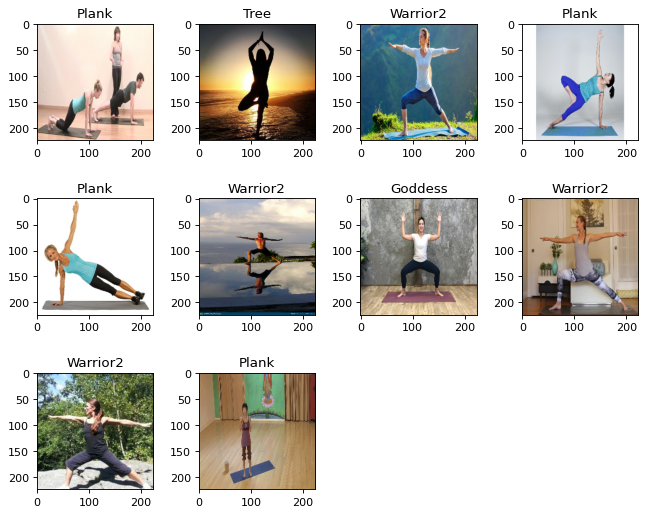

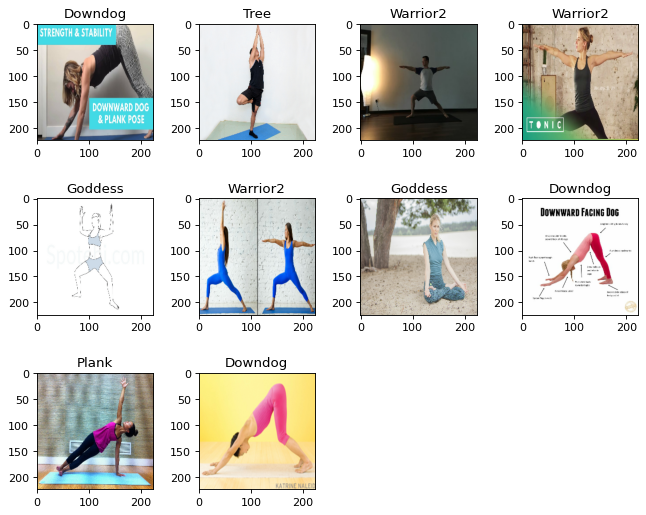

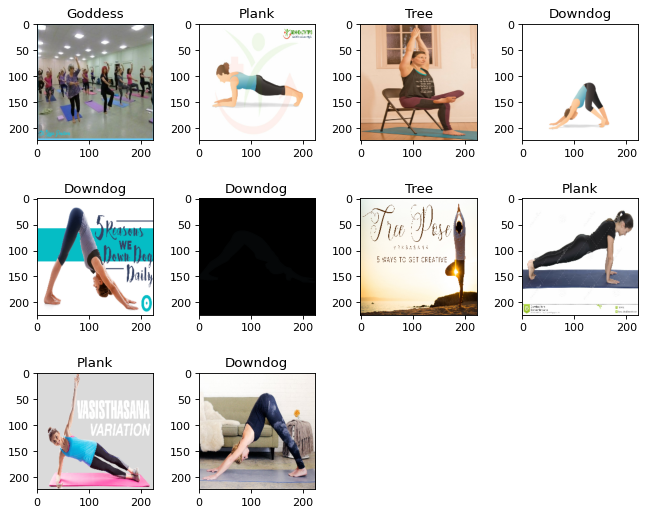

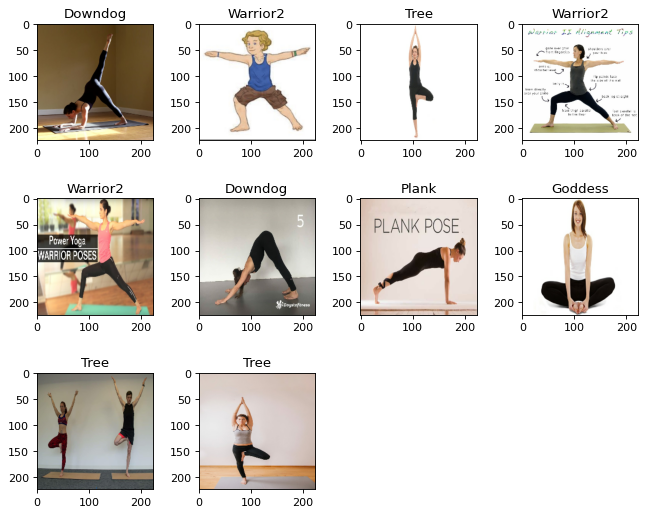

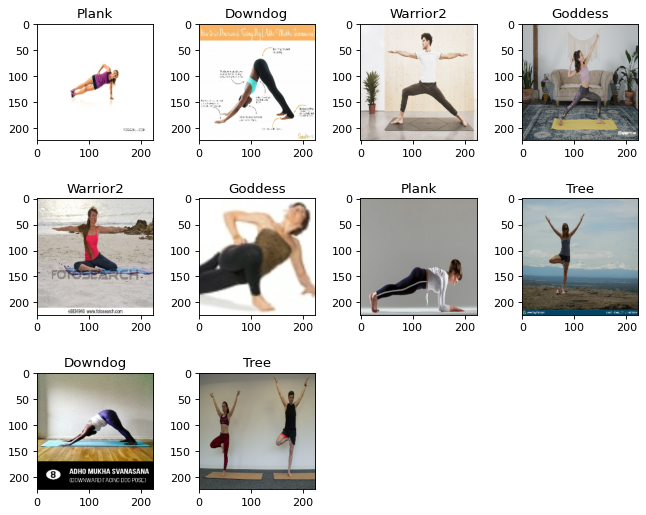

In [15]:
data_path = '/aiffel/model-fit/data/DATASET/TRAIN'
train_dataset = load_data(data_path, batch_size=10)
data_dir = pathlib.Path(data_path)
class_names = load_label(data_dir)

for img, label in train_dataset.take(5):
    show_batch(img, label, class_names)

In [16]:
data_dir = '/aiffel/model-fit/data/DATASET/TEST'
data_dir = pathlib.Path(data_path)

list_ds = tf.data.Dataset.list_files(str(data_dir / '*/*'))
for f in list_ds.take(5):
    print(f.numpy())

b'/aiffel/model-fit/data/DATASET/TRAIN/plank/00000413.jpg'
b'/aiffel/model-fit/data/DATASET/TRAIN/plank/00000380.jpg'
b'/aiffel/model-fit/data/DATASET/TRAIN/tree/00000127.jpg'
b'/aiffel/model-fit/data/DATASET/TRAIN/downdog/00000183.jpg'
b'/aiffel/model-fit/data/DATASET/TRAIN/downdog/00000210.jpg'


In [17]:
def process_path(file_path, class_names, img_shape=(224, 224)):
    label = tf.strings.split(file_path, os.path.sep) # file path parse해서 라벨 얻기 
    label = label[-2] == class_names # 라벨 인코딩

    img = tf.io.read_file(file_path) # 이미지 읽기
    img = tf.image.decode_jpeg(img, channels=3) # 이미지 파일 디코딩
    img = tf.image.convert_image_dtype(img, tf.float32) # 이미지 타입 변환
    img = tf.image.resize(img, img_shape) # 이미지 사이즈 변환
    return img, label
    
labeled_ds = list_ds.map(lambda x: process_path(x, class_names))
labeled_ds

<MapDataset shapes: ((224, 224, 3), (5,)), types: (tf.float32, tf.bool)>

In [18]:
def prepare_for_training(ds, batch_size=32, cache=True, shuffle_buffer_size=1000, n_repeat=3):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat(n_repeat)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

In [19]:
from tensorflow.keras.applications import EfficientNetB0

class YogaPose(tf.keras.Model):
    '''
    EfficientNetB0을 백본으로 사용하는 모델을 구성합니다.
    Classification 문제로 접근할 것이기 때문에 맨 마지막 Dense 레이어에 
    우리가 원하는 클래스 갯수 만큼을 지정해주어야 합니다.
    '''
    def __init__(self, num_classes=5, freeze=False):
        super(YogaPose, self).__init__()
        self.base_model = EfficientNetB0(include_top=False, weights='imagenet')
        if freeze:
            self.base_model.trainable = False
        self.top = tf.keras.Sequential([tf.keras.layers.GlobalAveragePooling2D(name="avg_pool"),
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Dropout(0.5, name="top_dropout")])
        self.classifier = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")
    def call(self, inputs, training=True):
        x = self.base_model(inputs)
        x = self.top(x)
        x = self.classifier(x)
        return x

if __name__ == '__main__':
    model = YogaPose(num_classes=5, freeze=True)
    model.build(input_shape=(None, 224, 224, 3))
    print(model.summary())

Model: "yoga_pose"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
sequential (Sequential)      (None, 1280)              5120      
_________________________________________________________________
pred (Dense)                 multiple                  6405      
Total params: 4,061,096
Trainable params: 8,965
Non-trainable params: 4,052,131
_________________________________________________________________
None


In [20]:
class Trainer:
    def __init__(self, model, epochs, batch, loss_fn, optimizer):
        self.model = model
        self.epochs = epochs
        self.batch = batch
        self.loss_fn = loss_fn
        self.optimizer = optimizer
    def train(self, train_dataset, train_metric):
        for epoch in range(self.epochs):
            print("\nStart of epoch %d" % (epoch,))
            # 매 batch 마다 반복적으로 학습
            for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
                with tf.GradientTape() as tape:
                    logits = model(x_batch_train, training=True)
                    loss_value = self.loss_fn(y_batch_train, logits)
                grads = tape.gradient(loss_value, model.trainable_weights)
                self.optimizer.apply_gradients(zip(grads, model.trainable_weights))
                # train metric 업데이트
                train_metric.update_state(y_batch_train, logits)
                # 5 배치마다 로깅
                if step % 5 == 0:
                    print(
                        "Training loss (for one batch) at step %d: %.4f"
                        % (step, float(loss_value))
                    )
                    print("Seen so far: %d samples" % ((step + 1) * self.batch))
                    print(train_metric.result().numpy())
                # 마지막 epoch 학습이 끝나면 train 결과를 보여줌
            train_acc = train_acc_metric.result()
            print("Training acc over epoch: %.4f" % (float(train_acc),))

In [21]:
epoch = 1
batch = 5
model = YogaPose(num_classes=5)
dataset = load_data(data_path=data_path, batch_size=batch)
loss_function = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
trainer = Trainer(model=model,
                  epochs=epoch,
                  batch=batch,
                  loss_fn=loss_function,
                  optimizer=optimizer)

trainer.train(train_dataset=dataset,
              train_metric=train_acc_metric)


Start of epoch 0


Corrupt JPEG data: premature end of data segment


Training loss (for one batch) at step 0: 2.0401
Seen so far: 5 samples
0.2
Training loss (for one batch) at step 5: 2.8590
Seen so far: 30 samples
0.16666667
Training loss (for one batch) at step 10: 1.8324
Seen so far: 55 samples
0.25454545
Training loss (for one batch) at step 15: 1.7066
Seen so far: 80 samples
0.3625
Training loss (for one batch) at step 20: 2.0743
Seen so far: 105 samples
0.40952381
Training loss (for one batch) at step 25: 1.2480
Seen so far: 130 samples
0.44615385
Training loss (for one batch) at step 30: 0.8070
Seen so far: 155 samples
0.4903226
Training loss (for one batch) at step 35: 1.3653
Seen so far: 180 samples
0.51666665
Training loss (for one batch) at step 40: 3.1436
Seen so far: 205 samples
0.52682924
Training loss (for one batch) at step 45: 3.7770
Seen so far: 230 samples
0.526087
Training loss (for one batch) at step 50: 1.9570
Seen so far: 255 samples
0.52156866
Training loss (for one batch) at step 55: 0.6601
Seen so far: 280 samples
0.53571427
T

Training loss (for one batch) at step 480: 0.0275
Seen so far: 2405 samples
0.69604987
Training loss (for one batch) at step 485: 1.4655
Seen so far: 2430 samples
0.69588476
Training loss (for one batch) at step 490: 0.0921
Seen so far: 2455 samples
0.6977597
Training loss (for one batch) at step 495: 0.0734
Seen so far: 2480 samples
0.6987903
Training loss (for one batch) at step 500: 2.3933
Seen so far: 2505 samples
0.7001996
Training loss (for one batch) at step 505: 1.8167
Seen so far: 2530 samples
0.7007905
Training loss (for one batch) at step 510: 1.0207
Seen so far: 2555 samples
0.7013699
Training loss (for one batch) at step 515: 0.0354
Seen so far: 2580 samples
0.701938
Training acc over epoch: 0.7019


In [22]:
def load_data(data_path, img_shape, batch_size=64, is_train=True):
    '''
    데이터를 만들기 위해 필요한 함수들을 호출하고 데이터를 리턴해주는 함수
    '''
    class_names = [cls for cls in os.listdir(data_path) if cls != '.DS_Store']
    data_path = pathlib.Path(data_path)
    
#     for item in data_path.glob("*"):
#         print(item.name)

    list_ds = tf.data.Dataset.list_files(str(data_path/'*/*'))
    labeled_ds = list_ds.map(lambda x: process_path(x, class_names, img_shape=img_shape))
    ds = prepare_for_training(labeled_ds, batch_size=batch_size)
    
    DATASET_SIZE = tf.data.experimental.cardinality(list_ds).numpy()

    return ds, DATASET_SIZE

In [23]:
'''
dataset.py의 코드입니다! 
'''
def process_path(file_path, class_names, img_shape=(224, 224)):
    label = tf.strings.split(file_path, os.path.sep)
    label = label[-2] == class_names

    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, img_shape)
    return img, label


def prepare_for_training(ds, batch_size=32, cache=True, shuffle_buffer_size=1000):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return ds


def load_label(data_path):
    class_names = [str(x) for x in data_path.iterdir()]
    print('Find {} class : {}'.format(len(class_names), class_names))
    return np.array(class_names)


def show_batch(image_batch, label_batch, class_names):
    size = len(image_batch)
    sub_size = int(size ** 0.5) + 1

    plt.figure(figsize=(10, 10), dpi=80)
    for n in range(size):
        plt.subplot(sub_size, sub_size, n+1)
        plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
        plt.title(class_names[np.array(label_batch[n])==True][0].title())
        plt.imshow(image_batch[n])
    plt.show()

def load_data(data_path, img_shape, batch_size=64, is_train=True):
    '''
    데이터를 만들기 위해 필요한 함수들을 호출하고 데이터를 리턴해주는 함수
    '''
    class_names = [cls for cls in os.listdir(data_path) if cls != '.DS_Store']
    print(class_names)
    data_path = pathlib.Path(data_path)
    
#     for item in data_path.glob("*"):
#         print(item.name)

    list_ds = tf.data.Dataset.list_files(str(data_path/'*/*'))
    labeled_ds = list_ds.map(lambda x: process_path(x, class_names, img_shape=img_shape))
    ds = prepare_for_training(labeled_ds, batch_size=batch_size)
    
    DATASET_SIZE = tf.data.experimental.cardinality(list_ds).numpy()

    return ds, DATASET_SIZE

In [24]:
import math

train_path = '/aiffel/model-fit/data/DATASET/TRAIN'
val_path = '/aiffel/model-fit/data/DATASET/VAL'
batch_size = 32

train_ds, TRAIN_SIZE = load_data(data_path=train_path, img_shape=(224, 224), batch_size=batch_size)
val_ds, VAL_SIZE = load_data(data_path=val_path, img_shape=(224, 224), batch_size=batch_size, is_train=False)

compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / batch_size))
steps_per_epoch = compute_steps_per_epoch(TRAIN_SIZE)
val_steps = compute_steps_per_epoch(VAL_SIZE)

['goddess', 'tree', 'plank', 'downdog', 'warrior2']
['goddess', 'tree', 'plank', 'downdog', 'warrior2']


In [25]:
# train, val 데이터 셋 모두 (224, 224, 3) 사이즈의 input과 5개의 label에 대하여 true false로 이루어진 GT가 들어가있는지 확인합니다
train_ds, val_ds

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 5)), types: (tf.float32, tf.bool)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 5)), types: (tf.float32, tf.bool)>)

In [26]:
from tensorflow.keras.utils import Progbar

class Trainer:
    def __init__(self, model, epochs, batch, loss_fn, optimizer):
        self.model = model
        self.epochs = epochs
        self.batch = batch
        self.loss_fn = loss_fn
        self.optimizer = optimizer

    def compute_acc(self, y_pred, y):
        correct = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        return accuracy

    @tf.function
    def train_on_batch(self, x_batch_train, y_batch_train):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)    # 모델이 예측한 결과
            train_loss = self.loss_fn(y_batch_train, logits)     # 모델이 예측한 결과와 GT를 이용한 loss 계산

        grads = tape.gradient(train_loss, model.trainable_weights)  # gradient 계산
        self.optimizer.apply_gradients(zip(grads, model.trainable_weights))  # Otimizer에게 처리된 그라데이션 적용을 요청

        return train_loss, logits

    def train(self, train_dataset, acc_metric, steps_per_epoch, val_dataset, val_step):
        metrics_names = ['train_loss', 'train_acc', 'val_loss']

        for epoch in range(self.epochs):
            print("\nEpoch {}/{}".format(epoch+1, self.epochs))

            train_dataset = train_dataset.shuffle(100)
            val_dataset = val_dataset.shuffle(100)

            train_dataset = train_dataset.take(steps_per_epoch)
            val_dataset = val_dataset.take(val_step)

            progBar = Progbar(steps_per_epoch * self.batch, stateful_metrics=metrics_names)

            train_loss, val_loss = 100, 100

            # 데이터 집합의 배치에 대해 반복합니다
            for step_train, (x_batch_train, y_batch_train) in enumerate(train_dataset):
                train_loss, logits = self.train_on_batch(x_batch_train, y_batch_train)

                # train metric(mean, auc, accuracy 등) 업데이트
                acc_metric.update_state(y_batch_train, logits)

                train_acc = self.compute_acc(logits, y_batch_train)
                values = [('train_loss', train_loss), ('train_acc', train_acc)]
                # print('{}'.format((step_train + 1) * self.batch))
                progBar.update((step_train + 1) * self.batch, values=values)

            for step, (x_batch_val, y_batch_val) in enumerate(val_dataset):
                logits = model(x_batch_val, training=False)
                val_loss = self.loss_fn(y_batch_val, logits)
                val_acc = self.compute_acc(logits, y_batch_val)
                values = [('train_loss', train_loss), ('train_acc', train_acc), ('val_loss', val_loss), ('val_acc', val_acc)]
            progBar.update((step_train + 1) * self.batch, values=values, finalize=True)

In [27]:
def process_path(file_path, class_names, img_shape=(224, 224)):
    label = tf.strings.split(file_path, os.path.sep)
    label = label[-2] == class_names

    img = tf.io.read_file(file_path)
    try:
        img = tf.image.decode_jpeg(img, channels=3)
    except tf.errors.InvalidArgumentError:
        print(f"Skipping corrupt image: {file_path}")
        img = tf.zeros([img_shape[0], img_shape[1], 3]) # 손상된 이미지 대신 빈 이미지 사용
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, img_shape)
    return img, label

In [28]:
loss_function = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.3)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
acc_metric = tf.keras.metrics.CategoricalAccuracy()

model = YogaPose(num_classes=5)

trainer = Trainer(model=model,
                  epochs=3,
                  batch=1,
                  loss_fn=loss_function,
                  optimizer=optimizer,)

trainer.train(train_dataset=train_ds,
            steps_per_epoch=steps_per_epoch,
            val_step=val_steps,
            val_dataset=val_ds,
            acc_metric=acc_metric)


Epoch 1/3


Corrupt JPEG data: premature end of data segment


27/27 [==============================] - 34s 508ms/step - train_loss: 1.7420 - train_acc: 0.5625 - val_loss: 1.5761 - val_acc: 0.2188

Epoch 2/3
27/27 [==============================] - 10s 340ms/step - train_loss: 1.7899 - train_acc: 0.5938 - val_loss: 1.6471 - val_acc: 0.1562

Epoch 3/3
27/27 [==============================] - 10s 339ms/step - train_loss: 1.5684 - train_acc: 0.6562 - val_loss: 1.5974 - val_acc: 0.1875


In [29]:
class Trainer:
    def __init__(self, model, epochs, batch, loss_fn, optimizer):
        self.model = model
        self.epochs = epochs
        self.batch = batch
        self.loss_fn = loss_fn
        self.optimizer = optimizer

    def compute_acc(self, y_pred, y):
        correct = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        return accuracy

    @tf.function
    def train_on_batch(self, x_batch_train, y_batch_train):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)    # 모델이 예측한 결과
            train_loss = self.loss_fn(y_batch_train, logits)     # 모델이 예측한 결과와 GT를 이용한 loss 계산

        grads = tape.gradient(train_loss, model.trainable_weights)  # gradient 계산
        self.optimizer.apply_gradients(zip(grads, model.trainable_weights))  # Otimizer에게 처리된 그라데이션 적용을 요청

        return train_loss, logits

    def train(self, train_dataset, acc_metric, steps_per_epoch, val_dataset, val_step, checkpoint_manager):
        metrics_names = ['train_loss', 'train_acc', 'val_loss']

        best_loss = 100
        for epoch in range(self.epochs):
            print("\nEpoch {}/{}".format(epoch+1, self.epochs))

            train_dataset = train_dataset.shuffle(100)
            val_dataset = val_dataset.shuffle(100)

            train_dataset = train_dataset.take(steps_per_epoch)
            val_dataset = val_dataset.take(val_step)

            progBar = Progbar(steps_per_epoch * self.batch, stateful_metrics=metrics_names)

            train_loss, val_loss = 100, 100

            # 데이터 집합의 배치에 대해 반복합니다
            for step_train, (x_batch_train, y_batch_train) in enumerate(train_dataset):
                train_loss, logits = self.train_on_batch(x_batch_train, y_batch_train)

                # train metric(mean, auc, accuracy 등) 업데이트
                acc_metric.update_state(y_batch_train, logits)

                train_acc = self.compute_acc(logits, y_batch_train)
                values = [('train_loss', train_loss), ('train_acc', train_acc)]
                # print('{}'.format((step_train + 1) * self.batch))
                progBar.update((step_train + 1) * self.batch, values=values)

            for step, (x_batch_val, y_batch_val) in enumerate(val_dataset):
                logits = model(x_batch_val, training=False)
                val_loss = self.loss_fn(y_batch_val, logits)
                val_acc = self.compute_acc(logits, y_batch_val)
                values = [('train_loss', train_loss), ('train_acc', train_acc), ('val_loss', val_loss), ('val_acc', val_acc)]
            progBar.update((step_train + 1) * self.batch, values=values, finalize=True)
            
            if val_loss < best_loss:
                best_loss = val_loss
                print("\nSave better model")
                print(checkpoint_manager.save())

In [30]:
loss_function = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.3)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) 
acc_metric = tf.keras.metrics.CategoricalAccuracy()

model = YogaPose(num_classes=5)

checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
manager = tf.train.CheckpointManager(checkpoint, directory="aiffel/model-fit/checkpoint", max_to_keep=5) #체크포인트 저장위치 자유롭게 변경

trainer = Trainer(model=model,
                  epochs=3,
                  batch=1,
                  loss_fn=loss_function,
                  optimizer=optimizer,)

trainer.train(train_dataset=train_ds,
            steps_per_epoch=steps_per_epoch,
            val_step=val_steps,
            val_dataset=val_ds,
            acc_metric=acc_metric,
            checkpoint_manager=manager)


Epoch 1/3
27/27 [==============================] - 17s 337ms/step - train_loss: 1.7542 - train_acc: 0.4375 - val_loss: 1.6582 - val_acc: 0.1875

Save better model
aiffel/model-fit/checkpoint/ckpt-1

Epoch 2/3
27/27 [==============================] - 10s 349ms/step - train_loss: 1.8524 - train_acc: 0.5938 - val_loss: 1.6268 - val_acc: 0.2500

Save better model
aiffel/model-fit/checkpoint/ckpt-2

Epoch 3/3
27/27 [==============================] - 10s 350ms/step - train_loss: 1.6046 - train_acc: 0.7188 - val_loss: 1.5937 - val_acc: 0.3125

Save better model
aiffel/model-fit/checkpoint/ckpt-3


In [31]:
# !pip install -q imageio
# !pip install -q opencv-python
!pip install -q git+https://github.com/tensorflow/docs

In [32]:
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import cv2

# matplotlib 라이브러리 import
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# 이미지 display를 도와주는 imageio import
import imageio
from IPython.display import HTML, display

model_name = "movenet_lightning"

if "movenet_lightning" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    input_size = 192
elif "movenet_thunder" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    input_size = 256
else:
    raise ValueError("Unsupported model name: %s" % model_name)

In [33]:
def movenet(module, input_image):
    """Runs detection on an input image.
    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.
    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores

In [34]:
from pathlib import Path

# 데이터 셋 위치
data_path = '/aiffel/model-fit/data/DATASET/TRAIN'
classes = [path for path in Path(data_path).iterdir() if path.is_dir()]
classes

[PosixPath('/aiffel/model-fit/data/DATASET/TRAIN/goddess'),
 PosixPath('/aiffel/model-fit/data/DATASET/TRAIN/tree'),
 PosixPath('/aiffel/model-fit/data/DATASET/TRAIN/plank'),
 PosixPath('/aiffel/model-fit/data/DATASET/TRAIN/downdog'),
 PosixPath('/aiffel/model-fit/data/DATASET/TRAIN/warrior2')]

In [36]:
train_files = []
for cls in classes:
    train_files += [x.as_posix() for x in Path(cls).glob('**/*') if x.is_file()]
train_files[:3], len(train_files)

(['/aiffel/model-fit/data/DATASET/TRAIN/goddess/00000102.jpg',
  '/aiffel/model-fit/data/DATASET/TRAIN/goddess/00000108.jpg',
  '/aiffel/model-fit/data/DATASET/TRAIN/goddess/00000281.jpg'],
 861)

In [37]:
data_path = '/aiffel/model-fit/data/DATASET/VAL'
classes = [path for path in Path(data_path).iterdir() if path.is_dir()]
val_files = []
for cls in classes:
    val_files += [x.as_posix() for x in Path(cls).glob('**/*') if x.is_file()]
val_files[:3], len(val_files)

(['/aiffel/model-fit/data/DATASET/VAL/goddess/00000282.png',
  '/aiffel/model-fit/data/DATASET/VAL/goddess/00000146.jpg',
  '/aiffel/model-fit/data/DATASET/VAL/goddess/00000246.jpg'],
 218)

In [38]:
data_path = '/aiffel/model-fit/data/DATASET/TEST'
classes = [path for path in Path(data_path).iterdir() if path.is_dir()]
test_files = []
for cls in classes:
    test_files += [x.as_posix() for x in Path(cls).glob('**/*') if x.is_file()]
test_files[:3], len(test_files)

(['/aiffel/model-fit/data/DATASET/TEST/goddess/00000012.jpg',
  '/aiffel/model-fit/data/DATASET/TEST/goddess/00000072.jpg',
  '/aiffel/model-fit/data/DATASET/TEST/goddess/00000023.jpg'],
 470)

In [39]:
def get_keypoints(image, 
                  keypoints_with_scores,
                  output_image_height=None, 
                  keypoint_threshold=0.0):
    height, width, channel = image.shape
    aspect_ratio = float(width) / height

    keypoints_all = []
    num_instances,_,_,_ = keypoints_with_scores.shape
    for id in range(num_instances):
        kpts_x = keypoints_with_scores[0,id,:,1]
        kpts_y = keypoints_with_scores[0,id,:,0]
        kpts_scores = keypoints_with_scores[0,id,:,2]
        kpts_abs_xy = np.stack(
            [width*np.array(kpts_x),height*np.array(kpts_y)],axis=-1)
        kpts_above_thrs_abs = kpts_abs_xy[kpts_scores > keypoint_threshold,: ]
        keypoints_all.append(kpts_above_thrs_abs)

    return np.concatenate(keypoints_all,axis=0)

In [40]:
import json

def make_keypoints_json(files, module, input_size):
    keypoints = {}
    removed = []
    for image_path in files:
        # 이미지 에러에 대한 처리
        # 이미지가 tf.io.read_file로 읽을 수 없는 타입인 경우에 대비
        try:
            image = tf.io.read_file(image_path)
            image = tf.image.decode_jpeg(image)
        except:
            print('image error : ', image_path)
            removed.append(image_path)
            continue

        input_image = tf.expand_dims(image, axis=0)
        input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

        # 모델 인퍼런스 에러에 대한 처리
        try:
            keypoints_with_scores = movenet(module, input_image)
            # print(keypoints_with_scores)
        except Exception as e:
#             print(input_image.shape)
            print('modl error : ', image_path)
            removed.append(image_path)
            continue

        keypoint_image = tf.expand_dims(image, axis=0)
        keypoint_image = tf.cast(tf.image.resize_with_pad(
            keypoint_image, 224, 224), dtype=tf.int32)
        output_overlay = get_keypoints(np.squeeze(keypoint_image.numpy(), axis=0), 
                                      keypoints_with_scores)
        # print(os.path.join('/'.join(image_path.split('/'))))
        keypoints.setdefault(os.path.join('/'.join(image_path.split('/'))), output_overlay.tolist())
        
    return keypoints, removed

In [41]:
train_keypoints, train_removed_files = make_keypoints_json(train_files, module, input_size)

modl error :  /aiffel/model-fit/data/DATASET/TRAIN/goddess/00000272.png


Corrupt JPEG data: premature end of data segment


modl error :  /aiffel/model-fit/data/DATASET/TRAIN/goddess/00000193.png
modl error :  /aiffel/model-fit/data/DATASET/TRAIN/goddess/00000127.png
modl error :  /aiffel/model-fit/data/DATASET/TRAIN/tree/00000154.png
modl error :  /aiffel/model-fit/data/DATASET/TRAIN/tree/00000140.png
modl error :  /aiffel/model-fit/data/DATASET/TRAIN/tree/00000145.png
modl error :  /aiffel/model-fit/data/DATASET/TRAIN/tree/00000131.png
modl error :  /aiffel/model-fit/data/DATASET/TRAIN/tree/00000200.png
modl error :  /aiffel/model-fit/data/DATASET/TRAIN/tree/00000090.png
modl error :  /aiffel/model-fit/data/DATASET/TRAIN/tree/00000203.png
modl error :  /aiffel/model-fit/data/DATASET/TRAIN/plank/00000136.png
modl error :  /aiffel/model-fit/data/DATASET/TRAIN/plank/00000179.png
modl error :  /aiffel/model-fit/data/DATASET/TRAIN/plank/00000204.png
modl error :  /aiffel/model-fit/data/DATASET/TRAIN/plank/00000236.png
modl error :  /aiffel/model-fit/data/DATASET/TRAIN/plank/00000170.png
modl error :  /aiffel/m

In [42]:
val_keypoints, val_removed_files = make_keypoints_json(val_files, module, input_size)

modl error :  /aiffel/model-fit/data/DATASET/VAL/goddess/00000282.png
modl error :  /aiffel/model-fit/data/DATASET/VAL/goddess/00000261.png
modl error :  /aiffel/model-fit/data/DATASET/VAL/tree/00000157.png
modl error :  /aiffel/model-fit/data/DATASET/VAL/plank/00000290.png
modl error :  /aiffel/model-fit/data/DATASET/VAL/plank/00000146.png
modl error :  /aiffel/model-fit/data/DATASET/VAL/plank/00000307.png
modl error :  /aiffel/model-fit/data/DATASET/VAL/downdog/00000349.png


In [43]:
test_keypoints, test_removed_files = make_keypoints_json(test_files, module, input_size)

modl error :  /aiffel/model-fit/data/DATASET/TEST/goddess/00000038.png
modl error :  /aiffel/model-fit/data/DATASET/TEST/goddess/00000006.png
modl error :  /aiffel/model-fit/data/DATASET/TEST/goddess/00000092.png
modl error :  /aiffel/model-fit/data/DATASET/TEST/tree/00000047.png
modl error :  /aiffel/model-fit/data/DATASET/TEST/tree/00000068.png
modl error :  /aiffel/model-fit/data/DATASET/TEST/tree/00000019.png
modl error :  /aiffel/model-fit/data/DATASET/TEST/plank/00000079.png
modl error :  /aiffel/model-fit/data/DATASET/TEST/plank/00000058.png
modl error :  /aiffel/model-fit/data/DATASET/TEST/plank/00000054.png
modl error :  /aiffel/model-fit/data/DATASET/TEST/plank/00000105.png
modl error :  /aiffel/model-fit/data/DATASET/TEST/plank/00000050.png
modl error :  /aiffel/model-fit/data/DATASET/TEST/plank/00000114.png
modl error :  /aiffel/model-fit/data/DATASET/TEST/plank/00000116.png
modl error :  /aiffel/model-fit/data/DATASET/TEST/downdog/00000041.png
modl error :  /aiffel/model-f

In [44]:
# # train, val keypoints 합쳐서 한 번에 저장하기
train_keypoints.update(val_keypoints)
train_keypoints.keys()
with open("aiffel/model-fit/keypoints_train_val.json", "w") as json_file:
    json.dump(train_keypoints, json_file)

# with open("/aiffel/aiffel/model-fit/keypoints_train_val.json", "r") as json_file:
#     keypoint_dict = json.load(json_file)
# keypoint_dict

In [45]:
# test keypoints 저장하기
with open("aiffel/model-fit/keypoints_test.json", "w") as json_file:
    json.dump(test_keypoints, json_file)

In [46]:
# keypoints_train_val.json, keypoints_test.json이 제대로 생겼는지 확인
!ls aiffel/model-fit

checkpoint  keypoints_test.json  keypoints_train_val.json


In [47]:
def remove_files(removed):
    for file_path in removed:
        try:
            os.remove(file_path)
        except:
            print(file_path)

In [48]:
remove_files(train_removed_files)
remove_files(val_removed_files)
remove_files(test_removed_files)

In [62]:
keypoint = {}

def process_keypoint(file_path):
    global keypoint_dict
    file_path = file_path.numpy().decode('utf-8')
    file_path = os.path.join('./', file_path)
    keypoint = tf.convert_to_tensor(keypoint_dict[file_path], dtype=tf.float32)
    return keypoint

def process_path(file_path, class_names, img_shape=(224, 224)):
    label = tf.strings.split(file_path, os.path.sep)
    label = label[-2] == class_names
    label = tf.cast(label, tf.float32)

    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, img_shape) 

    [keypoint,] = tf.py_function(process_keypoint, [file_path], [tf.float32])

    return {"input_1": img, "input_2": keypoint}, label

def augment(inputs, label):
    image, keypoint = inputs['input_1'], inputs['input_2']
    image = tf.image.random_crop(image, size=[224, 224, 3])
    image = tf.image.adjust_brightness(image, 0.4)
    image = tf.image.random_brightness(image, max_delta=0.4)
    return {'input_1' : image, 'input_2' : keypoint}, label


def prepare_for_training(ds, batch_size=32, cache=True, shuffle_buffer_size=1000, training=True):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    if training:
        ds = ds.map(lambda x, y: augment(x, y))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return ds


def load_label(data_path):
    class_names = [str(x) for x in data_path.iterdir()]
    print('Find {} class : {}'.format(len(class_names), class_names))
    return np.array(class_names)


def show_batch(image_batch, label_batch, class_names):
    size = len(image_batch)
    sub_size = int(size ** 0.5) + 1

    plt.figure(figsize=(10, 10), dpi=80)
    for n in range(size):
        plt.subplot(sub_size, sub_size, n+1)
        plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
        plt.title(class_names[np.array(label_batch[n])==True][0].title())
        plt.imshow(image_batch[n])
    plt.show()


def load_data(data_path, img_shape=(224, 224), batch_size=32, training=True):
    class_names = [cls for cls in os.listdir(data_path) if cls != '.DS_Store']
    data_path = pathlib.Path(data_path)

    list_ds = tf.data.Dataset.list_files(str(data_path/'*/*'))
    labeled_ds = list_ds.map(lambda x: process_path(x, class_names, img_shape=img_shape))
    ds = prepare_for_training(labeled_ds, batch_size=batch_size)

    DATASET_SIZE = tf.data.experimental.cardinality(list_ds).numpy()

    global keypoint_dict
    if training:
        with open("/aiffel/aiffel/aiffel/model-fit/keypoints_train_val.json", "r") as json_file:
            keypoint_dict = json.load(json_file)
    else:
        with open("/aiffel/aiffel/aiffel/model-fit/keypoints_test.json", "r") as json_file:
            keypoint_dict = json.load(json_file)

    return ds, DATASET_SIZE

In [63]:
ls /aiffel/model-fit/data/DATASET/TRAIN

downdog/  goddess/  plank/  tree/  warrior2/


In [64]:
# 내 데이터 위치
train_data_path = '/aiffel/model-fit/data/DATASET/TRAIN'

train_ds, train_size = load_data(data_path=train_data_path, img_shape=(224, 224), batch_size=1)

for inputs in train_ds.take(1):
    print(inputs)

Corrupt JPEG data: premature end of data segment


({'input_1': <tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=
array([[[[1.4601611 , 1.3929167 , 1.3535084 ],
         [1.3894762 , 1.3671023 , 1.3139335 ],
         [1.2632489 , 1.1513093 , 1.0395094 ],
         ...,
         [1.2239699 , 1.0906365 , 0.9416169 ],
         [1.2203677 , 1.0966101 , 0.94309133],
         [1.2147563 , 1.1010308 , 0.94416803]],

        [[1.4474146 , 1.3794446 , 1.3386533 ],
         [1.4182427 , 1.3955631 , 1.3358085 ],
         [1.2621284 , 1.1508801 , 1.0420392 ],
         ...,
         [1.228378  , 1.0989664 , 0.938182  ],
         [1.2279396 , 1.104182  , 0.9506633 ],
         [1.2185991 , 1.1048735 , 0.9480108 ]],

        [[1.4584959 , 1.3823385 , 1.3373053 ],
         [1.4193869 , 1.3952798 , 1.336001  ],
         [1.2722843 , 1.1642661 , 1.055425  ],
         ...,
         [1.2244458 , 1.0950341 , 0.93424976],
         [1.2266455 , 1.1018012 , 0.94444966],
         [1.2243676 , 1.1032629 , 0.94885993]],

        ...,

        [[1.4816158 ,

In [65]:
from tensorflow.keras.applications import VGG16

class YogaPose(tf.keras.Model):
    def __init__(self, num_classes=30, freeze=False):
        super(YogaPose, self).__init__()
        self.base_model = EfficientNetB0(include_top=False, weights='imagenet')
        self.keypoint = tf.keras.Sequential([tf.keras.layers.Flatten(input_shape=(17, 2)),
                                              tf.keras.layers.Dense(34),])
        
        if freeze:
            self.base_model.trainable = False

        self.top = tf.keras.Sequential([tf.keras.layers.GlobalAveragePooling2D(name="avg_pool"),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.Dropout(0.6, name="top_dropout")])
        
        self.concat = tf.keras.layers.Concatenate(axis=-1)
        self.classifier = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")

    def call(self, inputs, training=True):
        image, keypoint = inputs['input_1'], inputs['input_2']
        x1 = self.base_model(image)
        x1 = self.top(x1)
        x2 = self.keypoint(keypoint)
        x = self.concat([x1, x2])
        x = self.classifier(x)
        return x

In [66]:
# 가짜 input
inputs = {'input_1':tf.ones([1, 224, 224, 3]), 'input_2':tf.ones([1, 17, 2])}
model = YogaPose(num_classes=2, freeze=True)
model(inputs)

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.5499253, 0.4500747]], dtype=float32)>

In [67]:
from tensorflow.keras.utils import Progbar
import math

class Trainer:
    def __init__(self, model, epochs, batch, loss_fn, optimizer):
        self.model = model
        self.epochs = epochs
        self.batch = batch
        self.loss_fn = loss_fn
        self.optimizer = optimizer

    def compute_acc(self, y_pred, y):
        correct = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        return accuracy

    @tf.function
    def train_on_batch(self, x_batch_train, y_batch_train):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)    # 모델이 예측한 결과
            train_loss = self.loss_fn(y_batch_train, logits)     # 모델이 예측한 결과와 GT를 이용한 loss 계산

        grads = tape.gradient(train_loss, model.trainable_weights)  # gradient 계산
        self.optimizer.apply_gradients(zip(grads, model.trainable_weights))  # Otimizer에게 처리된 그라데이션 적용을 요청

        return train_loss, logits

    def train(self, train_dataset, acc_metric, steps_per_epoch, val_dataset, val_step):
        metrics_names = ['train_loss', 'train_acc', 'val_loss']

        for epoch in range(self.epochs):
            print("\nEpoch {}/{}".format(epoch+1, self.epochs))

            train_dataset = train_dataset.shuffle(100)
            val_dataset = val_dataset.shuffle(100)

            train_dataset = train_dataset.take(steps_per_epoch)
            val_dataset = val_dataset.take(val_step)

            progBar = Progbar(steps_per_epoch * self.batch, stateful_metrics=metrics_names)

            train_loss, val_loss = 100, 100

            # 데이터 집합의 배치에 대해 반복합니다
            for step_train, (x_batch_train, y_batch_train) in enumerate(train_dataset):
                train_loss, logits = self.train_on_batch(x_batch_train, y_batch_train)

                # train metric(mean, auc, accuracy 등) 업데이트
                acc_metric.update_state(y_batch_train, logits)

                train_acc = self.compute_acc(logits, y_batch_train)
                values = [('train_loss', train_loss), ('train_acc', train_acc)]
                # print('{}'.format((step_train + 1) * self.batch))
                progBar.update((step_train + 1) * self.batch, values=values)

            for step, (x_batch_val, y_batch_val) in enumerate(val_dataset):
                logits = model(x_batch_val, training=False)
                val_loss = self.loss_fn(y_batch_val, logits)
                val_acc = self.compute_acc(logits, y_batch_val)
                values = [('train_loss', train_loss), ('train_acc', train_acc), ('val_loss', val_loss), ('val_acc', val_acc)]
            progBar.update((step_train + 1) * self.batch, values=values, finalize=True)

In [68]:
train_data_path = '/aiffel/model-fit/data/DATASET/TRAIN' 
val_data_path = '/aiffel/model-fit/data/DATASET/VAL' 
batch_size = 16

train_ds, TRAIN_SIZE = load_data(data_path=train_data_path, img_shape=(224, 224), batch_size=batch_size)
val_ds, VAL_SIZE = load_data(data_path=val_data_path, img_shape=(224, 224), batch_size=batch_size)

In [69]:
compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / batch_size))
steps_per_epoch = compute_steps_per_epoch(TRAIN_SIZE)
val_steps = compute_steps_per_epoch(VAL_SIZE)

In [70]:
loss_function = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.3)  
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) 
acc_metric = tf.keras.metrics.CategoricalAccuracy()

model = YogaPose(num_classes=5)

# epoch을 조정해 보세요. 
trainer = Trainer(model=model,
                  epochs=100,
                  batch=1,
                  loss_fn=loss_function,
                  optimizer=optimizer,)

trainer.train(train_dataset=train_ds,
            steps_per_epoch=steps_per_epoch,
            val_step=val_steps,
            val_dataset=val_ds,
            acc_metric=acc_metric)


Epoch 1/100


Corrupt JPEG data: premature end of data segment


52/52 [==============================] - 37s 253ms/step - train_loss: 8.1480 - train_acc: 0.1875 - val_loss: 8.3483 - val_acc: 0.0625

Epoch 2/100
52/52 [==============================] - 12s 194ms/step - train_loss: 3.6710 - train_acc: 0.3750 - val_loss: 5.8482 - val_acc: 0.1875

Epoch 3/100
52/52 [==============================] - 12s 218ms/step - train_loss: 3.7752 - train_acc: 0.6875 - val_loss: 6.2601 - val_acc: 0.2500

Epoch 4/100
52/52 [==============================] - 11s 192ms/step - train_loss: 3.1690 - train_acc: 0.5625 - val_loss: 4.5906 - val_acc: 0.1875

Epoch 5/100
52/52 [==============================] - 11s 193ms/step - train_loss: 2.3372 - train_acc: 0.8125 - val_loss: 5.1340 - val_acc: 0.0625

Epoch 6/100
52/52 [==============================] - 11s 192ms/step - train_loss: 3.0429 - train_acc: 0.5625 - val_loss: 5.9857 - val_acc: 0.0625

Epoch 7/100
52/52 [==============================] - 11s 192ms/step - train_loss: 1.8820 - train_acc: 0.6875 - val_loss: 3.8495 - 


Epoch 35/100
52/52 [==============================] - 11s 195ms/step - train_loss: 1.3082 - train_acc: 0.8750 - val_loss: 4.2185 - val_acc: 0.3125

Epoch 36/100
52/52 [==============================] - 11s 195ms/step - train_loss: 1.5946 - train_acc: 0.6875 - val_loss: 4.9091 - val_acc: 0.4375

Epoch 37/100
52/52 [==============================] - 11s 194ms/step - train_loss: 1.5584 - train_acc: 0.8750 - val_loss: 1.5659 - val_acc: 0.5625

Epoch 38/100
52/52 [==============================] - 12s 217ms/step - train_loss: 1.3812 - train_acc: 0.8750 - val_loss: 2.4392 - val_acc: 0.3125

Epoch 39/100
52/52 [==============================] - 11s 194ms/step - train_loss: 1.4269 - train_acc: 0.8750 - val_loss: 8.8180 - val_acc: 0.1875

Epoch 40/100
52/52 [==============================] - 11s 191ms/step - train_loss: 1.4788 - train_acc: 0.8125 - val_loss: 1.9254 - val_acc: 0.7500

Epoch 41/100
52/52 [==============================] - 11s 192ms/step - train_loss: 1.2109 - train_acc: 0.9375 -


Epoch 69/100
52/52 [==============================] - 11s 193ms/step - train_loss: 1.2824 - train_acc: 0.8750 - val_loss: 1.8660 - val_acc: 0.6250

Epoch 70/100
52/52 [==============================] - 11s 193ms/step - train_loss: 1.3025 - train_acc: 0.8125 - val_loss: 3.0955 - val_acc: 0.3125

Epoch 71/100
52/52 [==============================] - 11s 193ms/step - train_loss: 1.2790 - train_acc: 0.8125 - val_loss: 1.6340 - val_acc: 0.6875

Epoch 72/100
52/52 [==============================] - 11s 193ms/step - train_loss: 1.1209 - train_acc: 0.9375 - val_loss: 2.2229 - val_acc: 0.4375

Epoch 73/100
52/52 [==============================] - 11s 195ms/step - train_loss: 1.1009 - train_acc: 1.0000 - val_loss: 1.6667 - val_acc: 0.3750

Epoch 74/100
52/52 [==============================] - 11s 194ms/step - train_loss: 1.1091 - train_acc: 1.0000 - val_loss: 1.4151 - val_acc: 0.6875

Epoch 75/100
52/52 [==============================] - 11s 196ms/step - train_loss: 1.1365 - train_acc: 1.0000 -

In [71]:
num_classes = 1 
epoch = 1 
batch_size = 16
img_size = 224
test_data_path =  '/aiffel/model-fit/data/DATASET/TEST'

checkpoint_path = './checkpoints/'

model = YogaPose(num_classes=num_classes)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

test, TEST_SIZE = load_data(data_path=test_data_path, img_shape=(img_size, img_size), batch_size=batch_size, training=False)

checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

for step_train, (x_batch_train, y_batch_train) in enumerate(test.take(10)):
    # print(model(x_batch_train))
    prediction = model(x_batch_train)
    # print(tf.argmax(y_batch_train, axis=1))
    # print(tf.argmax(prediction, axis=1))
    # print(tf.equal(tf.argmax(y_batch_train, axis=1), tf.argmax(prediction, axis=1)))
    print("{}/{}".format(np.array(tf.equal(tf.argmax(y_batch_train, axis=1), tf.argmax(prediction, axis=1))).sum(), tf.argmax(y_batch_train, axis=1).shape[0]))
    # print("Prediction: {}".format(tf.argmax(prediction, axis=1)))

3/16
2/16
1/16
3/16
0/16
2/16
2/16
2/16
2/16
2/16
